In [3]:

from tensorflow.keras.layers import Conv2D,Input,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from PIL import Image

def preprocess(im):
    
    im = im/255
    im -= .5
    return im


def load_image_batch(ids, batch_size=32):
    
    image_batch = np.zeros((batch_size, im_size, im_size, channel))
    
    label_hour = np.zeros((batch_size, 1))
    label_min = np.zeros((batch_size, 1))
    batch_ids = np.random.choice(ids, batch_size)
    
    ind = 0
    for i in range(len(batch_ids)):
        
        if channel == 1:
            im = Image.open(path + str(batch_ids[i]) + '.jpg').convert('L')
        else:
            im = Image.open(path + str(batch_ids[i]) + '.jpg')
        im = im.resize((im_size,im_size), Image.ANTIALIAS)
        im = np.array(im)
        image_batch[ind] = preprocess(im).reshape((im_size, im_size, channel))
        label_hour[ind] = (data['hour'][data.index==batch_ids[i]])
        label_min[ind] = (data['minute'][data.index==batch_ids[i]])/60
        ind += 1
            
    return (np.array(image_batch), np.array(label_hour), np.array(label_min))



inp = Input(shape=(100, 100, 1))
# Convolutional Layers
x = Conv2D(50, kernel_size=5, strides=2, activation='relu')(inp)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = Conv2D(100, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(150, kernel_size=3, strides=1, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(200, kernel_size=3, strides=1, activation='relu')(x)
x = Dropout(.4)(x)
x = Flatten()(x)

# Hour branch
hour = Dense(144, activation='relu')(x)
hour = Dense(12, activation='softmax', name='hour')(hour)

# Minute Branch
minute = Dense(100, activation='relu')(x)
minute = Dense(1, activation='linear', name='minute')(minute)

model = Model(inputs=inp, outputs=[hour, minute])
optimizer = Adam(lr=0.001, clipnorm=0.001)
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], optimizer=optimizer, metrics=['accuracy', 'mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 48, 48, 50)   1300        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 24, 24, 50)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 22, 22, 100)  45100       max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [2]:
data = pd.read_csv('analog_clocks/label.csv')

channel = 1
im_size = 100
path = 'analog_clocks/images/'

train_ids = np.arange(10000)
test_ids = np.arange(500) + len(train_ids)

x_train, y1_train, y2_train = load_image_batch(train_ids, len(train_ids))

x_test, y1_test, y2_test = load_image_batch(test_ids, len(train_ids))

In [5]:

print('# Fit model on training data')
history = model.fit(x_train, [y1_train, y2_train],
                    batch_size=64,
                    epochs=200,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(x_test, [y1_test, y2_test]))

print('\nhistory dict:', history.history)

# Fit model on training data
Train on 10000 samples, validate on 10000 samples
Epoch 1/200
10000/10000 [==============================] - 37s 4ms/sample - loss: 0.2581 - hour_loss: 0.2190 - minute_loss: 0.0390 - hour_accuracy: 0.9254 - hour_mae: 5.4497 - minute_accuracy: 0.0148 - minute_mae: 0.1544 - val_loss: 0.4770 - val_hour_loss: 0.4284 - val_minute_loss: 0.0485 - val_hour_accuracy: 0.8488 - val_hour_mae: 5.4339 - val_minute_accuracy: 0.0234 - val_minute_mae: 0.1705
Epoch 2/200
10000/10000 [==============================] - 40s 4ms/sample - loss: 0.2299 - hour_loss: 0.1931 - minute_loss: 0.0376 - hour_accuracy: 0.9352 - hour_mae: 5.4497 - minute_accuracy: 0.0145 - minute_mae: 0.1510 - val_loss: 0.4336 - val_hour_loss: 0.3919 - val_minute_loss: 0.0430 - val_hour_accuracy: 0.8583 - val_hour_mae: 5.4339 - val_minute_accuracy: 0.0155 - val_minute_mae: 0.1591
Epoch 3/200
10000/10000 [==============================] - 41s 4ms/sample - loss: 0.1837 - hour_loss: 0.1493 - minute_loss: 0.035

KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt
import numpy
# load pima indians dataset
model.save_weights('weights.h5')
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['hour_accuracy'])
plt.plot(history.history['val_hour_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history.history['minute_accuracy'])
plt.plot(history.history['val_minute_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history.history['hour_mae'])
plt.plot(history.history['val_hour_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history.history['minute_mae'])
plt.plot(history.history['val_minute_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [64]:
I = load_image_batch(232, 1)
I[1:]
I = cv2.imread('clock_no_center.jpeg')
gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I = cv2.resize(gray, (100,100))
I = np.expand_dims(I, axis=0)
I = np.expand_dims(I, axis=3)
I.shape

(1, 100, 100, 1)

In [65]:

print(np.argmax(model.predict(I)[0]))
model.predict(I)

9


[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32),
 array([[10.504467]], dtype=float32)]

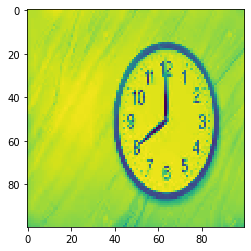

In [66]:
plt.imshow(I[0,:,:,0])

In [11]:
import cv2
I = cv2.imread('prueba.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I = cv2.resize(I, (100,100))
I = np.expand_dims(I, axis=0)
I = np.expand_dims(I, axis=3)
I.shape

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [12]:
print(np.argmax(model.predict(I)[0]))
print(model.predict(I)[1])
A = I[0,:,:,0]
A.shape
plt.imshow(A)

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

In [13]:
model.predict(I)

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>